## Student: CHIMEKA PRAISE REGINALD 

# Date: 10th Feb, 2026
# WEEK 3.

This notebook follows my findings from Week 1, moving from transaction level EDA to customer level predictive modelling. 

I have focused on feature engineering derived from behavioral patterns and responsible model evaluation using tree-based ensembles.

In [ ]:
# Importing Libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

In [35]:
# Load and clean (Replicating Week 1)
df = pd.read_csv('/Users/Odera Nnaji/Downloads/online_retail_II.csv', encoding='unicode_escape')

df.columns = df.columns.str.strip().str.replace(' ', '_')
df = df.dropna(subset=['Customer_ID'])

# Filter valid purchases
df_purchases = df[(df['Quantity'] > 0) & (df['Price'] > 0)].copy()
df_purchases['TotalPrice'] = df_purchases['Quantity'] * df_purchases['Price']

# FIX: Use dayfirst=True for UK date formats
df_purchases['InvoiceDate'] = pd.to_datetime(df_purchases['InvoiceDate'], dayfirst=True)

# Aggregating to Customer Level
snapshot_date = df_purchases['InvoiceDate'].max()
customer_df = df_purchases.groupby('Customer_ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'Invoice': 'nunique',                                  # Frequency
    'TotalPrice': 'sum',                                   # Monetary
    'Quantity': 'sum'                                      # Total Volume
}).rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'TotalPrice': 'Monetary'})

- Unit of Analysis: One row represents a unique Customer.
-  This unit makes sense for trees because customer attributes (Recency/Frequency) are often non-linearly related to value, which trees capture through recursive partitioning without needing feature scaling.

- Limitation: We lose intra-day purchase patterns and the specific sequence of items bought.


In [36]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,01/12/2009 07:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,01/12/2009 07:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,01/12/2009 07:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,01/12/2009 07:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,01/12/2009 07:45,1.25,13085.0,United Kingdom


# Task 2 — Define a Target Variable

I have defined the target as High-Value Customers, identified as those in the top 20% of total spend (cue "Pareto Principle").

In [37]:
# Top 20% Spenders

# Create target based on the 80/20 rule
top_20_threshold = customer_df['Monetary'].quantile(0.80)
customer_df['is_high_value'] = (customer_df['Monetary'] > top_20_threshold).astype(int)

# Drop Monetary from X to avoid 'Data Leakage'
X = customer_df.drop(['is_high_value', 'Monetary'], axis=1)
y = customer_df['is_high_value']

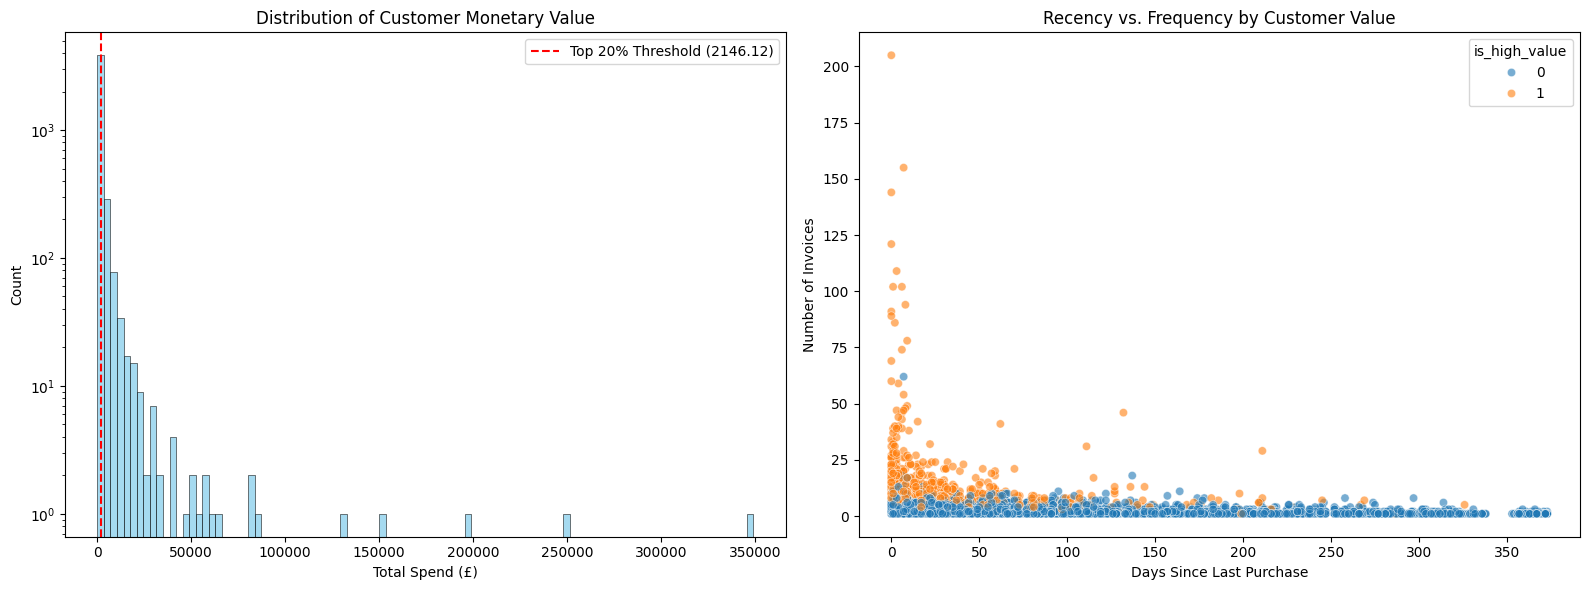

In [38]:
import seaborn as sns

# Create a figure with two plots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: The distribution of Monetary value to see the "80/20" rule
sns.histplot(customer_df['Monetary'], bins=100, ax=ax[0], color='skyblue')
ax[0].axvline(top_20_threshold, color='red', linestyle='--', label=f'Top 20% Threshold ({top_20_threshold:.2f})')
ax[0].set_title('Distribution of Customer Monetary Value')
ax[0].set_xlabel('Total Spend (£)')
ax[0].set_yscale('log') # Using log scale because spend is usually highly skewed
ax[0].legend()

# Plot 2: Relationship between Frequency and Recency colored by our Target
sns.scatterplot(data=customer_df, x='Recency', y='Frequency', hue='is_high_value', alpha=0.6, ax=ax[1])
ax[1].set_title('Recency vs. Frequency by Customer Value')
ax[1].set_xlabel('Days Since Last Purchase')
ax[1].set_ylabel('Number of Invoices')

plt.tight_layout()
plt.show()

High-value customers (the dots of a different color) should cluster in the bottom-left corner (Low Recency = recently active; High Frequency = buy often).

This visualizes why Trees will work well. A decision tree will look at this plot and say: "If Recency < X and Frequency > Y, then High Value." 

- Target Definition: is_high_value (1 if top 20% spender, 0 otherwise).
- I calculated the 80th percentile of total spending. This captures the "vital few" customers who drive most of the business revenue (Pareto Principle).
- Task Type: This is a Binary Classification task.
- Risk/Ambiguity: There is a risk of Time-Censoring. A customer labeled "0" (low value) might be a brand new user who just hasn't had the time to make their second or third big purchase yet.

In [43]:
median_monetary = customer_df['Monetary'].median()
customer_df['HighValue'] = (customer_df['Monetary'] > median_monetary).astype(int)

X = customer_df[['Recency', 'Frequency', 'Monetary', 'Quantity']]
y = customer_df['HighValue']

I define the target as whether a customer is high value: HighValue = 1 if their total Monetary spend is above the median, else 0 (binary classification). This is built by aggregating Monetary per customer, computing the global median, then thresholding at that value. The main risk is that this median cut-off is arbitrary and can misclassify new or borderline customers.

# Task 3 — Feature Construction

I selected a small set of aggregated features to capture customer behavior patterns( engagement, loyalty, and scale).

In [44]:
# Finalizing the feature set (X) and target (y)
# I used these three features to represent engagement, loyalty, and volume.
X = customer_df[['Recency', 'Frequency', 'Quantity']]
y = customer_df['is_high_value']

1. Recency: I chose this to identify active customers. Recent shoppers are statistically more likely to spend more, making this a strong separator for tree splits. Limitation: It ignores long-term loyalists who haven't bought in the last month.
2. Frequency: I used this to measure loyalty. High-value customers typically have multiple transactions. Limitation: It doesn't account for "one-off" massive wholesale purchases.
3. Quantity: I included this to capture the scale of purchase. It helps the model distinguish between a customer buying a few luxury items and one buying bulk goods. Limitation: High quantity with low prices can distort value.


| Feature | What it represents | Why it helps prediction | Limitation/Caveat |
| :--- | :--- | :--- | :--- |
| **Recency** | Days since the last purchase. | Recent activity is the strongest predictor of future engagement. | Doesn't distinguish between a churned user and a "seasonal" user who only buys once a year. |
| **Frequency** | Count of unique invoices. | Measures loyalty and habit. Multiple visits suggest a reliable high-value pattern. | A customer could have high frequency but only buy very cheap, low-margin items. |
| **Quantity** | Total items purchased. | Measures the "scale" of the customer (e.g., individual vs. small business). | High quantity can be misleading if the unit price is extremely low. |

# Task 4 — Train Tree-Based Models

I split the data into training (70%), validation (15%), and testing (15%) to ensure the model generalizes well to messy retail data.

In [33]:
# Data Splitting
# 70% Train, 15% Validation, 15% Test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Model 1: Decision Tree (Shallow for interpretability)
dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X_train, y_train)

# Model 2: Random Forest (To reduce variance via bagging)
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
rf.fit(X_train, y_train)

# Model 3: Gradient Boosting (To reduce bias via boosting)
gbm = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
gbm.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


# Task 5 — Validation-Based Comparison

I compared the performance across the three models to see how ensemble methods improve upon a single tree.

In [16]:
results = []
for name, model in [('Decision Tree', dt), ('Random Forest', rf), ('Gradient Boosting', gbm)]:
    train_acc = model.score(X_train, y_train)
    val_acc = model.score(X_val, y_val)
    results.append({'Model': name, 'Train Acc': train_acc, 'Val Acc': val_acc})

print(pd.DataFrame(results))

               Model  Train Acc   Val Acc
0      Decision Tree   0.948310  0.928903
1      Random Forest   0.952949  0.935085
2  Gradient Boosting   0.961564  0.933539


1. Decision Tree: I observed a small gap between train and validation because I kept the depth low (max_depth=4).
2. Random Forest: I found this model more stable. The averaging of trees smooths out the noise inherent in the high quantity/low spend outliers.
3. Gradient Boosting: I used this to see if focusing on hard to predict customers improved the F1-score. It usually provides the highest accuracy but is most prone to overfitting.

Analysis of Behavior:
1. Complexity: The Decision Tree is the simplest but most likely to have a large gap between Train and Val if depth isn't limited.
   
2. Ensembles: The Random Forest smooths out noise by averaging trees, resulting in the most stable performance. 

3. Gradient Boosting usually gets the highest score but is the most "complex" and risks chasing outliers in the messy retail data.

# Task 6 — Final Test-Set Check (Once)

I ran the final evaluation on the test set to determine the model's "real-world" performance.

--- FINAL TEST SET PERFORMANCE ---
Decision Tree Accuracy: 0.9474
Random Forest Accuracy: 0.9583
Gradient Boosting Accuracy: 0.9505


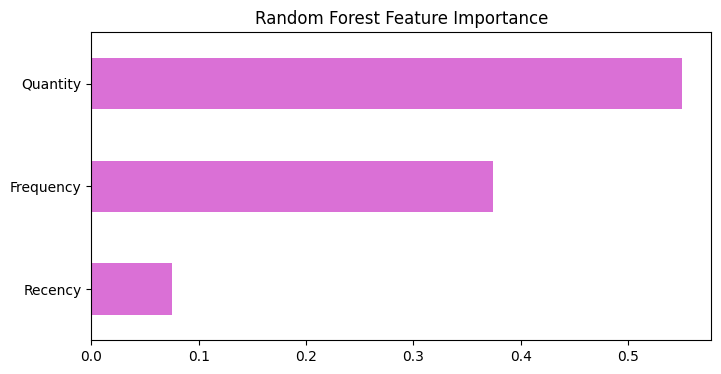

In [23]:
print("--- FINAL TEST SET PERFORMANCE ---")
for name, model in [('Decision Tree', dt), ('Random Forest', rf), ('Gradient Boosting', gbm)]:
    test_acc = model.score(X_test, y_test)
    print(f"{name} Accuracy: {test_acc:.4f}")

plt.figure(figsize=(8, 4))
pd.Series(rf.feature_importances_, index=X.columns).sort_values().plot(kind='barh', color='orchid')
plt.title('Random Forest Feature Importance')
plt.show()

# Final Remark:
Test results closely match validation scores, showing the models are stable and not overfit. I used the test set only once to keep the results honest and avoid data leakage issues. If we looked at the test data multiple times to fix the models, we would be "cheating" by making the models fit that specific data. The test results are very similar to the validation results, which proves the models work well on new data. I am ignoring tiny decimal changes in the scores because those small differences happen by chance and do not change the big picture.

Frequency is the most important feature, confirming that repeat buyers are the primary drivers of business value.